# Data Analysis

Let's go back to the alignment data to perform some publication-grade analysis that includes:

1. **Data wrangling**
2. **Statistics**
    * scipy.stats
    * statsmodels
3. **Visulisation**

First we will import the libraries we need.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np
import os

Then we set the seaborn `context` as `notebook` and `palette` as `colorblind`.

In [ ]:
sns.set(context='notebook')
sns.set_palette("colorblind")

Now, imoprt the raw alignment data as `Pandas` dataframe.

In [ ]:
CommonDf = pd.read_csv('../Day4/data/CommonDf.tsv', sep='\t', index_col=0)
CommonDf.head()

We can also import the file that contains column label's description.

In [ ]:
LabelsDf = pd.read_csv('../Day4/data/ColumnsInDf.txt', sep='\t')
LabelsDf

Find some descriptive statistical measures for the numerical columns.

In [ ]:
CommonDf.describe()

Note that form the `Subs` columns onward the count is below than that for the `_aa` columns.

Let's check the rows where `overlap` data is missing.

In [ ]:
CommonDf[CommonDf.overlap.isna()].loc[:,:'overlap']

We see that in both cases, one of the four orthlogs has been truncated. Possibly, the ortholog has acquired a nonsense mutation. We will drop these orthologs from further analysis.

In [ ]:
CommonDf.dropna(inplace=True, subset=['overlap'])
CommonDf.describe()

## Length distribution
First we will analyse the length distibution of these orthlogs, so lets create a list with the column labels for the length variables.

In [ ]:
AaLs = [x for x in CommonDf.columns if x.endswith('_aa')]
AaLs

### Longest and Shortest orthlogs
Find the longest (`Max`) and the shortest (`Min`) ortholog in each family.

In [ ]:
# Length of the shortest ortholog
CommonDf['Min'] = CommonDf[AaLs].apply(min, axis=1)
# Length of the longest ortholog
CommonDf['Max'] = CommonDf[AaLs].apply(max, axis=1)
# scatter plot of the shortest and longest orthlogs with their linear regression line
sns.regplot(x="Min", y="Max", data=CommonDf, y_jitter=0.05,
            line_kws={'color':'red'}).set(
    xlabel='Shortest Ortholog', 
    ylabel='Longest Ortholog');

The closer the slope of the regression line isto one, lesser is the difference between the two variables being plotted. So, let's find the slope:

In [ ]:
from scipy.stats import linregress
linregress(CommonDf.Min, CommonDf.Max)

### Length difference

The length difference between the shortest and longest orthlogs is the maximum ortholog length difference (`MaxDif`) for the given family. However, to compare length difference across families we will calculate the relative length diference by computing the `RelMaxDif`. It will be the `MaxDif` per 100 residues of the shortest ortholog.

In [ ]:
CommonDf['MaxDif'] = CommonDf[AaLs].apply(lambda row: (max(row) - min(row)), axis=1)
CommonDf['MaxDif'] = CommonDf['Max'] - CommonDf['Min']
CommonDf['RelMaxDif'] = CommonDf['MaxDif']*100/CommonDf['Min']
sns.histplot(CommonDf[CommonDf['RelMaxDif'] > 0]['RelMaxDif'], 
             bins=range(0,20,1),).set(
    xlabel="Length difference (%)", 
    ylabel="Ortholog Families");

So it appears that the majority of the ortholog families show less than 5% length difference.

In [ ]:
len(CommonDf[CommonDf.RelMaxDif <= 5])*100/len(CommonDf)

This suggests that we have aligned proteins of comparable lenghts and our alignment overlap should encompass the entire length of the orthlogs (at least the shortest ortholog).

### Relative overlap represent the extent of alignment saturation

The alignment overlap (`overlap`), which is the maximum number of aligned residues, within any family cannot excede the length of its shortest ortholog. Thus, we can calculate the alignment saturation (`RelOverlap`) as the number of aligned residue per 100 residue of the shortest ortholog.

In [ ]:
CommonDf['RelOverlap'] = CommonDf['overlap']*100/CommonDf['Min']
sns.histplot(CommonDf['RelOverlap'], bins=range(90,101,1)).set(
    xlabel="Aligment Saturation (%)", 
    ylabel="Ortholog Families");

### Identical sites

We already have the percent idenity (`AbsId`) of our alignments as the number of identical sites per 100 residue of the shortest orhtolog.

In [ ]:
sns.histplot(CommonDf['%AbsId'], bins=range(90,101,1)).set(
    xlim=(90,100), 
    xlabel="Idenity (%)\n(within aligned region)", 
    ylabel="Ortholog Families");

In [ ]:
sns.violinplot(data=CommonDf[['RelOverlap', '%AbsId']])
sns.stripplot(data=CommonDf[['RelOverlap', '%AbsId']], palette='bright', jitter=0.03, size =2, alpha=0.3,)

We can choose from the above plots to make a single publishable figure:

In [ ]:
plt.close('all')
plt.clf()
plt.rcParams['pdf.fonttype'] = 'truetype'
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3,figsize=(10,4))
#figure 1a scatterplot for min and max distribution of each cluster
sns.regplot(x="Min", y="Max", data=CommonDf, y_jitter=0.05, line_kws={'color':'red'}, ax=ax1)
ax1.set(xticks=range(0,5001,1000), xlim=(0,5500), ylim=(0,5500), xlabel="Shortest Ortholog\n(aa residues)", ylabel="Longest Ortholog\n(aa residues)")
plt.setp(ax1.get_xmajorticklabels(), rotation=30)
ax1.set_title('a', fontdict={'fontsize':30}, loc='left') 
#figure 1b %maxdiff histogram
sns.histplot(CommonDf[CommonDf['RelMaxDif'] > 0]['RelMaxDif'], bins=range(0,15,1), ax=ax2)
#counts, bins, patches = ax3.hist(CommonDf[CommonDf['%MaxDif'] > 0]['%MaxDif'], bins=10)
ax2.set(xticks=range(1,20,1), xlim=(0,15), xlabel="Length difference (%)", ylabel="Ortholog Families")
plt.setp(ax2.get_xmajorticklabels()[1::2], visible=False)
ax2.set_title('b', fontdict={'fontsize':30}, loc='left') 
# figure 1c Violinplot
sns.violinplot(data=CommonDf[['RelOverlap', '%AbsId']], ax=ax3)
sns.stripplot(data=CommonDf[['RelOverlap', '%AbsId']], palette='bright', jitter=0.03, size =2, alpha=0.3, ax=ax3)
ax3.set(xlabel = '', ylabel = '', xticklabels=["Aligment Saturation (%)", "Idenity (%)\n(within aligned region)"])
ax3.set(xlabel = '', ylabel = '', xticklabels=["Aligment\nSaturation (%)", "Idenity (%)"])
ax3.set_title('c', fontdict={'fontsize':30}, loc='left') 
plt.tight_layout(pad=1.08)
plt.savefig('Fig1_OrthologFamilies.pdf')
plt.savefig('Fig1_OrthologFamilies.png')


### gridspec
For greater subplot position control we can use `matplotlib.gridspec`.

In [ ]:
import matplotlib.gridspec as gridspec
plt.close('all')
plt.clf()
plt.rcParams['pdf.fonttype'] = 'truetype'
fig2 = plt.figure(figsize=(21,6))
spec2 = gridspec.GridSpec(ncols=4, nrows=1, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax2 = fig2.add_subplot(spec2[0, 1:-1])
ax3 = fig2.add_subplot(spec2[0, -1])
plt.figure()

In [ ]:
plt.close('all')
plt.clf()
plt.rcParams['pdf.fonttype'] = 'truetype'
fig2 = plt.figure(figsize=(12,6))
spec2 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, :-1])
ax2 = fig2.add_subplot(spec2[1, :-1])
ax3 = fig2.add_subplot(spec2[:, -1])
#figure 1a scatterplot for min and max distribution of each cluster
sns.regplot(x="Min", y="Max", data=CommonDf, y_jitter=0.05, line_kws={'color':'red'}, ax=ax1)
ax1.set(xticks=range(0,5001,1000), xlim=(0,5500), ylim=(0,5500), xlabel="Shortest Ortholog\n(aa residues)", ylabel="Longest Ortholog\n(aa residues)")
plt.setp(ax1.get_xmajorticklabels(), rotation=30)
ax1.set_title('a', fontdict={'fontsize':30}, loc='left') 
#figure 1b %maxdiff histogram
sns.histplot(CommonDf[CommonDf['RelMaxDif'] > 0]['RelMaxDif'], bins=range(0,15,1), ax=ax2)
#counts, bins, patches = ax3.hist(CommonDf[CommonDf['%MaxDif'] > 0]['%MaxDif'], bins=10)
ax2.set(xticks=range(1,20,1), xlim=(0,15), xlabel="Length difference (%)", ylabel="Ortholog Families")
plt.setp(ax2.get_xmajorticklabels()[1::2], visible=False)
ax2.set_title('b', fontdict={'fontsize':30}, loc='left') 
# figure 1c Violinplot
sns.violinplot(data=CommonDf[['RelOverlap', '%AbsId']], ax=ax3)
sns.stripplot(data=CommonDf[['RelOverlap', '%AbsId']], palette='bright', jitter=0.03, size =2, alpha=0.3, ax=ax3)
ax3.set(xlabel = '', ylabel = '', xticklabels=["Aligment Saturation (%)", "Idenity (%)\n(within aligned region)"])
ax3.set(xlabel = '', ylabel = '', xticklabels=["Aligment\nSaturation (%)", "Idenity (%)"])
ax3.set_title('c', fontdict={'fontsize':30}, loc='left') 
plt.tight_layout(pad=1.08)
plt.savefig('Fig1.1_OrthologFamilies.pdf')
plt.savefig('Fig1.1_OrthologFamilies.png')

### Substitutions

Let's get a list of columns that represent percent specis-specific substituions.

In [118]:
SubsLs = [x for x in CommonDf.columns if ('_Subs' in x and '%' in x and '#' not in x)]
SubsLs

['%HS_Subs', '%PT_Subs', '%GG_Subs', '%NL_Subs']

<AxesSubplot:>

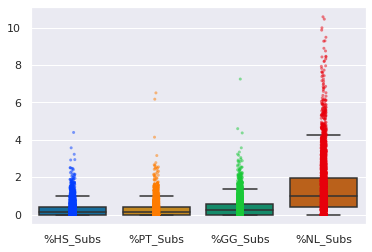

In [119]:
sns.boxplot(data=CommonDf[SubsLs], showfliers=False)
sns.stripplot(data=CommonDf[SubsLs], palette='bright', jitter=0.03, size =3, alpha=0.5,)

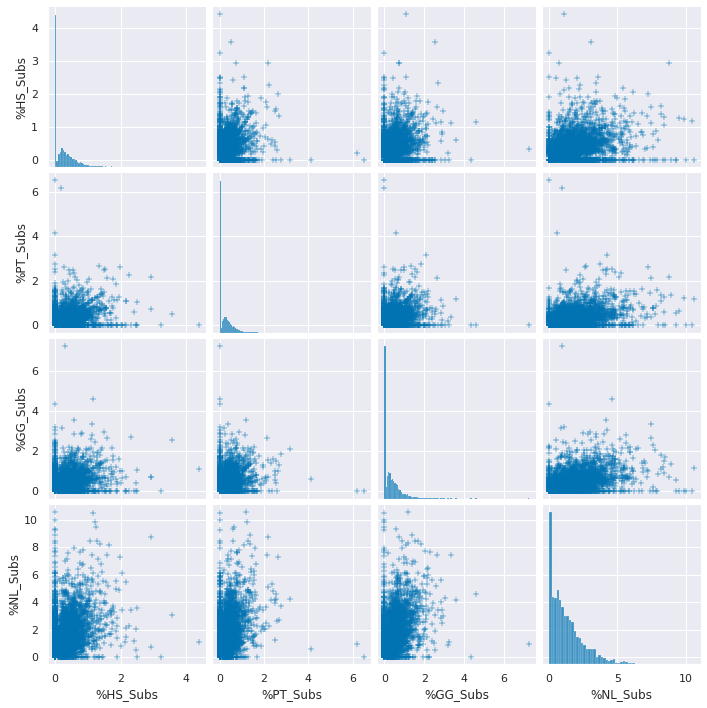

In [120]:
sns.pairplot(data=CommonDf, vars=SubsLs, markers='+')

A correlation pattern, if any, is not very obvious between the % subs.

In [121]:
from scipy.stats import spearmanr as spearmanr
spearmanr(CommonDf[SubsLs])

SpearmanrResult(correlation=array([[1.        , 0.35656009, 0.36201819, 0.43965783],
       [0.35656009, 1.        , 0.37993299, 0.46095692],
       [0.36201819, 0.37993299, 1.        , 0.50944805],
       [0.43965783, 0.46095692, 0.50944805, 1.        ]]), pvalue=array([[0.00000000e+000, 9.67302871e-150, 1.23973939e-154,
        2.38335734e-235],
       [9.67302871e-150, 0.00000000e+000, 2.23538301e-171,
        1.77139790e-261],
       [1.23973939e-154, 2.23538301e-171, 0.00000000e+000,
        0.00000000e+000],
       [2.38335734e-235, 1.77139790e-261, 0.00000000e+000,
        0.00000000e+000]]))

In [122]:
cor_df, pval_df = spearmanr(CommonDf[SubsLs])
cor_df = pd.DataFrame(cor_df, index=SubsLs, columns=SubsLs)
pval_df = pd.DataFrame(pval_df, index=SubsLs, columns=SubsLs)
print("Spearman's rho:\n", cor_df)
print("\nSpearman's pvalue:\n", pval_df)

Spearman's rho:
           %HS_Subs  %PT_Subs  %GG_Subs  %NL_Subs
%HS_Subs  1.000000  0.356560  0.362018  0.439658
%PT_Subs  0.356560  1.000000  0.379933  0.460957
%GG_Subs  0.362018  0.379933  1.000000  0.509448
%NL_Subs  0.439658  0.460957  0.509448  1.000000

Spearman's pvalue:
                %HS_Subs       %PT_Subs       %GG_Subs       %NL_Subs
%HS_Subs   0.000000e+00  9.673029e-150  1.239739e-154  2.383357e-235
%PT_Subs  9.673029e-150   0.000000e+00  2.235383e-171  1.771398e-261
%GG_Subs  1.239739e-154  2.235383e-171   0.000000e+00   0.000000e+00
%NL_Subs  2.383357e-235  1.771398e-261   0.000000e+00   0.000000e+00


We can plot the correlation matrix as a heat map:

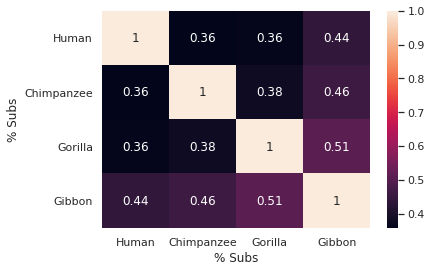

In [123]:
sns.heatmap(cor_df, annot=True).set(
    xlabel='% Subs',
    ylabel='% Subs',
    xticklabels=['Human', 'Chimpanzee', 'Gorilla','Gibbon'], 
    yticklabels=['Human', 'Chimpanzee', 'Gorilla','Gibbon']);

## Data transformation

Let's assume that our substituion data is a result of a **Poisson process**. Thus, to get an accurate substituion rate we need to perform **Poisson correction** on the absolute number of substituions.

In [124]:
#Make a list of columns that contain absolute number of substituions
AbsSubsLs = [x for x in CommonDf.columns if ('_Subs' in x and '%' not in x and '#' not in x)]
AbsSubsLs

['HS_Subs', 'PT_Subs', 'GG_Subs', 'NL_Subs']

In [125]:
#make a copy of the columns thah have Absolute substitution values
PcDf = CommonDf[AbsSubsLs].copy(deep=True)
#drop zero substituions families
PcDf = PcDf[(PcDf[AbsSubsLs] > 0).any(axis=1)]
# Perform Poisson correction
PcDf = PcDf.apply(lambda row: -np.log(1-row/(CommonDf.at[row.name, 'overlap'])), axis=1)
PcDf.describe()

,HS_Subs,PT_Subs,GG_Subs,NL_Subs
count,4557.000000,4557.000000,4557.000000,4557.000000
mean,0.002892,0.002731,0.003893,0.015150
std,0.003691,0.003814,0.004701,0.013724
min,-0.000000,-0.000000,-0.000000,-0.000000
25%,-0.000000,-0.000000,-0.000000,0.005485
50%,0.001969,0.001729,0.002692,0.011544
75%,0.004444,0.004132,0.005775,0.020803
max,0.044951,0.067366,0.075322,0.111918


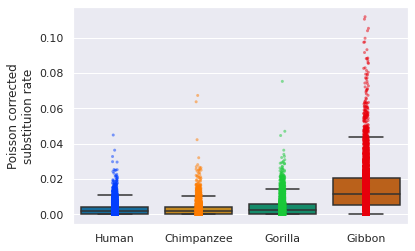

In [126]:
sns.boxplot(data=PcDf, showfliers=False)
sns.stripplot(data=PcDf, palette='bright', jitter=0.03, size =3, alpha=0.5,).set(
    xlabel='',
    ylabel='Poisson corrected\nsubstituion rate',
    xticklabels=['Human', 'Chimpanzee', 'Gorilla','Gibbon'],);

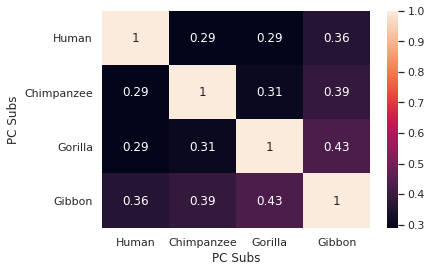

In [136]:
Pc_cor_df, Pc_pval_df = spearmanr(PcDf)
Pc_cor_df = pd.DataFrame(Pc_cor_df, index=SubsLs, columns=SubsLs)
Pc_pval_df = pd.DataFrame(Pc_pval_df, index=SubsLs, columns=SubsLs)
sns.heatmap(Pc_cor_df, annot=True).set(
    xlabel='PC Subs',
    ylabel='PC Subs',
    xticklabels=['Human', 'Chimpanzee', 'Gorilla','Gibbon'], 
    yticklabels=['Human', 'Chimpanzee', 'Gorilla','Gibbon']);

### Family-wise PC Subs normalisation
We can normalise the substituion rate in each family to facilitate cross family comparision. A simple method for this is to take the PC Subs for each species of the given family one at a time and divide them with the sum of PC Subs of all species for the faily.

In [128]:
NormPcDf = PcDf.apply(lambda row: row/row.sum(), axis=1).copy()

In [129]:
NormPcDf.describe()

,HS_Subs,PT_Subs,GG_Subs,NL_Subs
count,4557.000000,4557.000000,4557.000000,4557.000000
mean,0.125438,0.112792,0.162469,0.599301
std,0.167758,0.155673,0.185199,0.248002
min,-0.000000,-0.000000,-0.000000,-0.000000
25%,-0.000000,-0.000000,-0.000000,0.500000
50%,0.090175,0.078185,0.132827,0.608544
75%,0.181449,0.166162,0.230388,0.750713
max,1.000000,1.000000,1.000000,1.000000


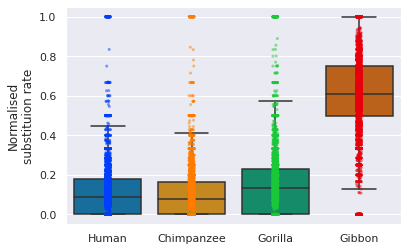

In [130]:
sns.boxplot(data=NormPcDf, showfliers=False)
sns.stripplot(data=NormPcDf, palette='bright', jitter=0.03, size =3, alpha=0.5,).set(
    xlabel='',
    ylabel='Normalised\nsubstituion rate',
    xticklabels=['Human', 'Chimpanzee', 'Gorilla','Gibbon'],);

Let's check if hte normalised substituion rates are normally distributed.

<Figure size 432x288 with 0 Axes>

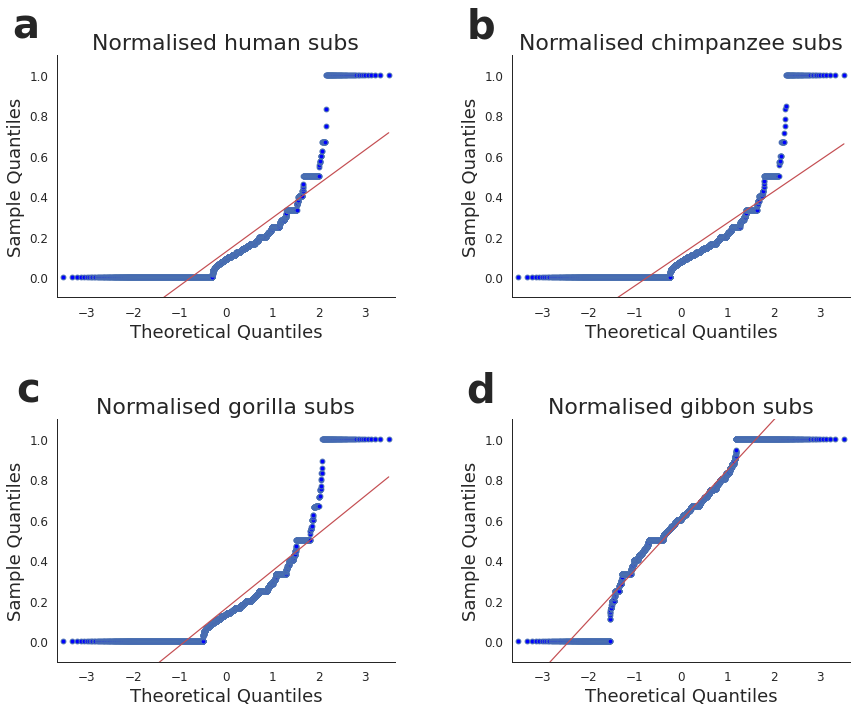

In [205]:
with plt.rc_context(dict(sns.axes_style("white", rc = {
    'axes.spines.right': False,
    'axes.spines.top': False,}),
                         **sns.plotting_context("paper", rc={
                             'axes.labelsize':18, 
                             'axes.titlesize': 22,
                             'xtick.labelsize': 12,
                             'ytick.labelsize': 12,}))):
    from statsmodels.graphics.gofplots import qqplot
    plt.close('all')
    plt.clf()
    plt.rcParams['pdf.fonttype'] = 'truetype'
    fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
    qqplot(NormPcDf.HS_Subs, line='s', ax=ax2)
    ax2.text(-0.05, 1.2, 'a', transform=ax2.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
    ax2.set_title('Normalised human subs',)
    ax2.set_xlabel('Theoretical Quantiles')
    ax2.set_ylabel('Sample Quantiles')
    ax2.set(ylim=(-0.1,1.1))
    qqplot(NormPcDf.PT_Subs, line='s', ax=ax3)
    ax3.text(-0.05, 1.2, 'b', transform=ax3.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
    ax3.set_title('Normalised chimpanzee subs',)
    ax3.set_xlabel('Theoretical Quantiles')
    ax3.set_ylabel('Sample Quantiles')
    ax3.set(ylim=(-0.1,1.1))
    qqplot(NormPcDf.GG_Subs, line='s', ax=ax4)
    ax4.text(-0.05, 1.2, 'c', transform=ax4.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
    ax4.set_title('Normalised gorilla subs',)
    ax4.set_xlabel('Theoretical Quantiles')
    ax4.set_ylabel('Sample Quantiles')
    ax4.set(ylim=(-0.1,1.1))
    qqplot(NormPcDf.NL_Subs, line='s', ax=ax5)
    ax5.text(-0.05, 1.2, 'd', transform=ax5.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
    ax5.set_title('Normalised gibbon subs',)
    ax5.set_xlabel('Theoretical Quantiles')
    ax5.set_ylabel('Sample Quantiles')
    ax5.set(ylim=(-0.1,1.1))
    plt.tight_layout(pad=1.08, h_pad=3, w_pad=7)
    plt.savefig('Fig2.1_qqplt.pdf')
    plt.savefig('Fig2.1_qqplt.png')

In [202]:
ax4.transAxes?

Type:           BboxTransformTo
String form:   
BboxTransformTo(
           TransformedBbox(
           Bbox(x0=0.0690601851851852, y0=0.07453888888888893, <...>        [[72.  0.  0.]
           [ 0. 72.  0.]
           [ 0.  0.  1.]])))))
File:           /opt/conda/lib/python3.8/site-packages/matplotlib/transforms.py
Docstring:     
`BboxTransformTo` is a transformation that linearly transforms points from
the unit bounding box to a given `Bbox`.
Init docstring:
Create a new `BboxTransformTo` that linearly transforms
points from the unit bounding box to *boxout*.


In [132]:
from scipy.stats import normaltest
for cols in NormPcDf.columns:
    print(cols, '\n', normaltest(NormPcDf[cols]), '\n',)

HS_Subs 
 NormaltestResult(statistic=2616.7203178416303, pvalue=0.0) 

PT_Subs 
 NormaltestResult(statistic=2821.3075450951424, pvalue=0.0) 

GG_Subs 
 NormaltestResult(statistic=2069.431266228854, pvalue=0.0) 

NL_Subs 
 NormaltestResult(statistic=176.78248753186313, pvalue=4.0942144231216e-39) 



In [134]:
help(normaltest)

Help on function normaltest in module scipy.stats.stats:

normaltest(a, axis=0, nan_policy='propagate')
    Test whether a sample differs from a normal distribution.
    
    This function tests the null hypothesis that a sample comes
    from a normal distribution.  It is based on D'Agostino and
    Pearson's [1]_, [2]_ test that combines skew and kurtosis to
    produce an omnibus test of normality.
    
    Parameters
    ----------
    a : array_like
        The array containing the sample to be tested.
    axis : int or None, optional
        Axis along which to compute test. Default is 0. If None,
        compute over the whole array `a`.
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan.
        The following options are available (default is 'propagate'):
    
          * 'propagate': returns nan
          * 'raise': throws an error
          * 'omit': performs the calculations ignoring nan values
    
    Returns
  